In [1]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
from common.utils import draw_chart
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

polars.config.Config

In [2]:
POJISTOVNA = "cpzp"
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

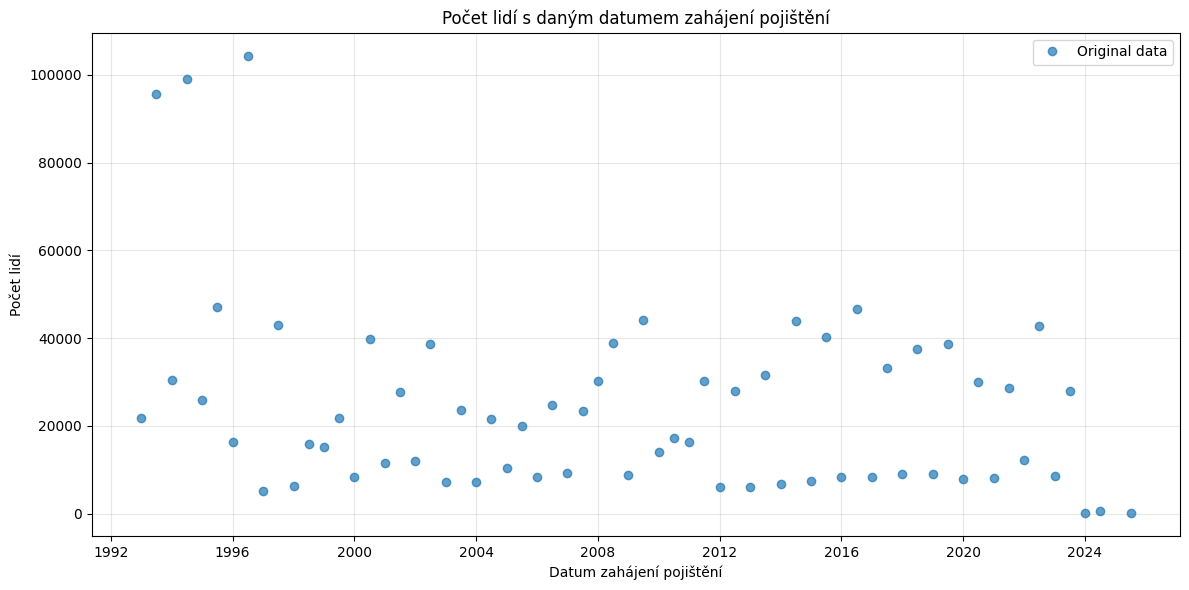

In [5]:
datum_zahajeni_pojisteni_map = {}
for person in persons:
    if person.zahajeni_pojisteni < datetime(1980, 1, 1).date():
        continue
    if person.zahajeni_pojisteni not in datum_zahajeni_pojisteni_map:
        datum_zahajeni_pojisteni_map[person.zahajeni_pojisteni] = 1
    else:
        datum_zahajeni_pojisteni_map[person.zahajeni_pojisteni] += 1

draw_chart(
    mapp=datum_zahajeni_pojisteni_map,
    x_label="Datum zahájení pojištění",
    y_label="Počet lidí",
    title="Počet lidí s daným datumem zahájení pojištění",
    average=False,
)

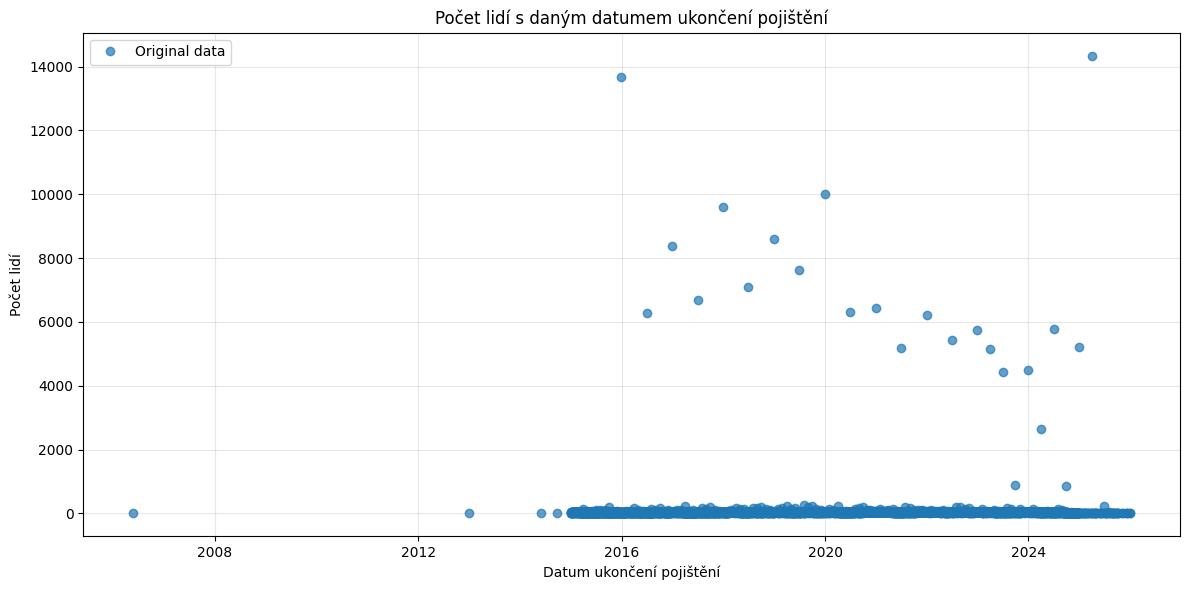

In [9]:
datum_ukonceni_pojisteni_map = {}
for person in persons:
    if (
        person.ukonceni_pojisteni < datetime(1980, 1, 1).date()
        or person.ukonceni_pojisteni > datetime(2026, 1, 1).date()
    ):
        continue
    if person.ukonceni_pojisteni not in datum_ukonceni_pojisteni_map:
        datum_ukonceni_pojisteni_map[person.ukonceni_pojisteni] = 1
    else:
        datum_ukonceni_pojisteni_map[person.ukonceni_pojisteni] += 1

draw_chart(
    mapp=datum_ukonceni_pojisteni_map,
    x_label="Datum ukončení pojištění",
    y_label="Počet lidí",
    title="Počet lidí s daným datumem ukončení pojištění",
    average=False,
)

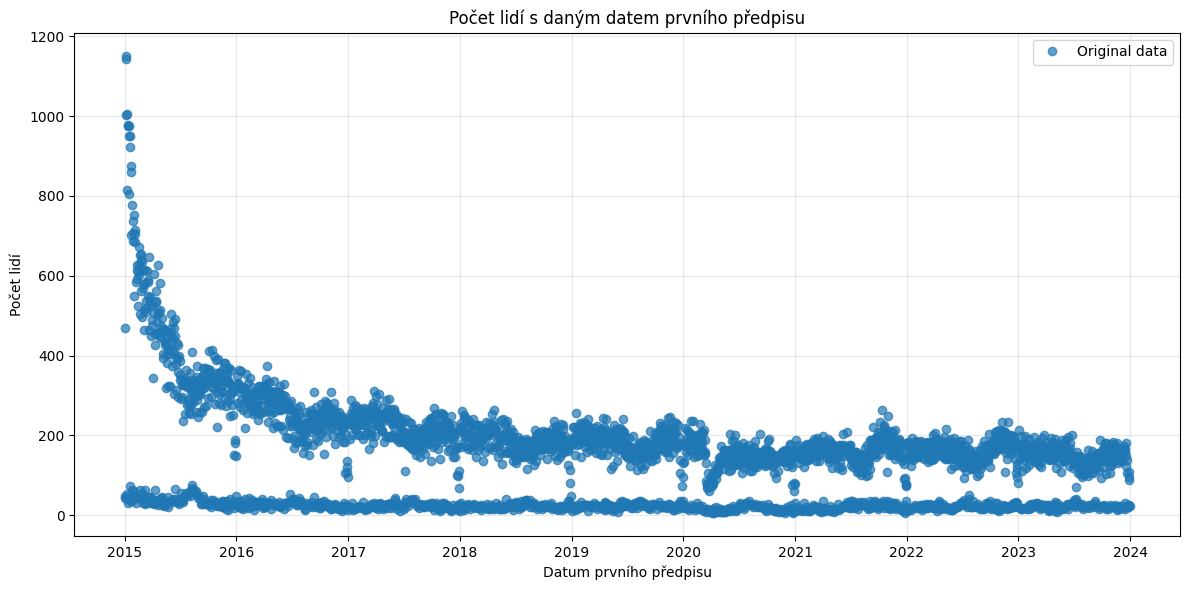

In [ ]:
datum_predpisu = {}
for person in persons:
    if not person.prescriptions:
        continue
    prvopredpis_date = person.prescriptions[0].date
    if prvopredpis_date not in datum_predpisu:
        datum_predpisu[prvopredpis_date] = 1
    else:
        datum_predpisu[prvopredpis_date] += 1

draw_chart(
    mapp=datum_predpisu,
    x_label="Datum prvního předpisu",
    y_label="Počet lidí",
    title="Počet lidí s daným datem prvního předpisu",
    average=False,
)

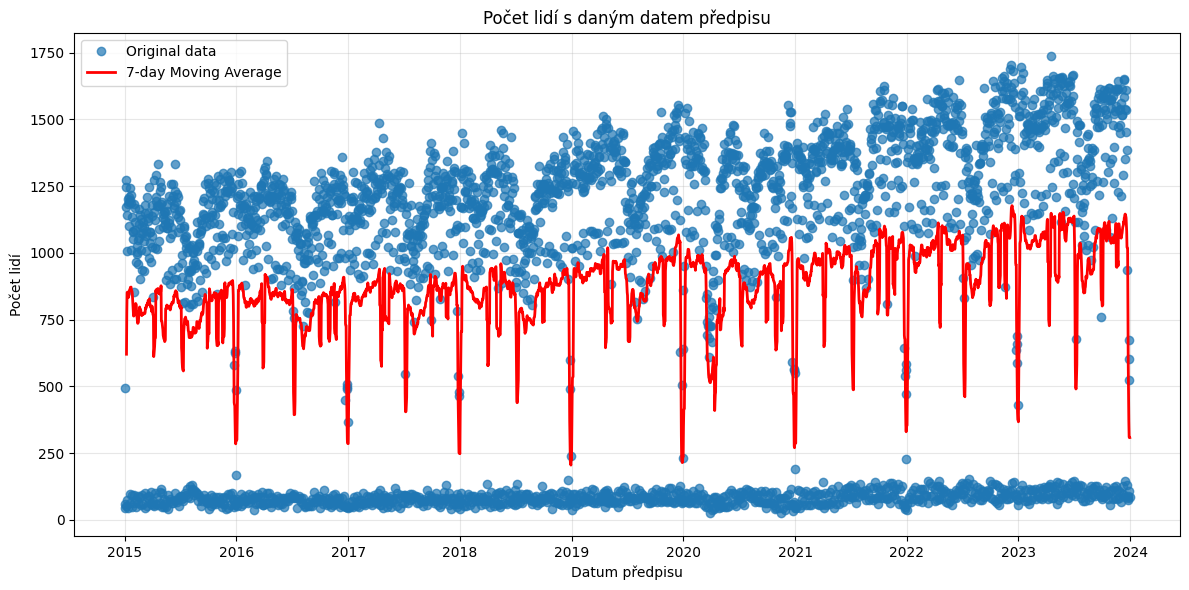

In [ ]:
datum_predpisu = {}
for person in persons:
    if not person.prescriptions:
        continue
    for prescription in person.prescriptions:
        if prescription.date not in datum_predpisu:
            datum_predpisu[prescription.date] = 1
        else:
            datum_predpisu[prescription.date] += 1

draw_chart(
    mapp=datum_predpisu,
    x_label="Datum předpisu",
    y_label="Počet lidí",
    title="Počet lidí s daným datem předpisu",
    average=30,
)